In [3]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [4]:
# Install the necessary libraries quietly
!pip install -q ultralytics pyyaml

# Data processing 

In [5]:
import os
import shutil

# --- Configuration ---
# The source directory with your original, messy labels
source_data_dir = '/kaggle/input/3-class-scrap-dataset/kaggle_data'
# A new directory where we will save the clean, corrected dataset
corrected_data_dir = '/kaggle/working/corrected_dataset'

# DEFINE THE FINAL, CORRECT CLASS MAPPING. This is our "source of truth".
# The order here determines the final class IDs.
FINAL_CLASSES = ['cardboard', 'metal', 'plastic'] 

# --- Main Correction Script ---
print("--- Starting Automatic Label Correction ---")

# Clean up any previous runs
if os.path.exists(corrected_data_dir):
    shutil.rmtree(corrected_data_dir)

# Create the new directory structure
corrected_images_dir = os.path.join(corrected_data_dir, 'images')
corrected_labels_dir = os.path.join(corrected_data_dir, 'labels')
os.makedirs(corrected_images_dir, exist_ok=True)
os.makedirs(corrected_labels_dir, exist_ok=True)

source_labels_dir = os.path.join(source_data_dir, 'labels')
files_processed = 0

for filename in os.listdir(source_labels_dir):
    if not filename.endswith('.txt'):
        continue

    # 1. Determine the TRUE class from the filename
    true_class_name = None
    if 'cardboard' in filename.lower():
        true_class_name = 'cardboard'
    elif 'metal' in filename.lower():
        true_class_name = 'metal'
    elif 'plastic' in filename.lower():
        true_class_name = 'plastic'
    
    if true_class_name is None:
        print(f"Warning: Could not determine class for '{filename}'. Skipping.")
        continue

    # 2. Find the CORRECT new class ID from our FINAL_CLASSES list
    try:
        new_class_id = FINAL_CLASSES.index(true_class_name)
    except ValueError:
        print(f"Warning: Class '{true_class_name}' from filename '{filename}' not in FINAL_CLASSES. Skipping.")
        continue

    # 3. Read the old file, replace the ID, and write to a new file
    source_label_path = os.path.join(source_labels_dir, filename)
    corrected_label_path = os.path.join(corrected_labels_dir, filename)
    
    with open(source_label_path, 'r') as f_in, open(corrected_label_path, 'w') as f_out:
        new_lines = []
        for line in f_in:
            parts = line.strip().split()
            # We only use the bounding box parts (last 4 numbers)
            bbox_coords = ' '.join(parts[1:]) 
            # We create a new line with the CORRECT ID
            new_lines.append(f"{new_class_id} {bbox_coords}")
        f_out.write('\n'.join(new_lines))
    
    # 4. Copy the corresponding image to the new dataset
    basename = os.path.splitext(filename)[0]
    for ext in ['.jpg', '.jpeg', '.png']:
        img_path = os.path.join(source_data_dir, 'images', basename + ext)
        if os.path.exists(img_path):
            shutil.copy(img_path, corrected_images_dir)
            break
    
    files_processed += 1

print(f"\nProcessed and corrected {files_processed} label files.")
print(f"Clean dataset is now ready at: {corrected_data_dir}")
print("--- Correction Complete ---")

--- Starting Automatic Label Correction ---

Processed and corrected 150 label files.
Clean dataset is now ready at: /kaggle/working/corrected_dataset
--- Correction Complete ---


In [6]:
import os
import shutil
import random
import yaml

# --- Configuration ---
# IMPORTANT: The source is now our 'corrected_data_dir' from the previous cell
source_dir = '/kaggle/working/corrected_dataset'
output_dir = '/kaggle/working/scrap_dataset_split'
CLASS_NAMES = ['cardboard', 'metal', 'plastic'] # Must match Cell 1
train_split_ratio = 0.8

# --- Main Script ---
print("--- Starting Dataset Split ---")

if os.path.exists(output_dir):
    shutil.rmtree(output_dir)

source_images_dir = os.path.join(source_dir, 'images')
image_basenames = [os.path.splitext(f)[0] for f in os.listdir(source_images_dir)]
random.shuffle(image_basenames)

split_point = int(len(image_basenames) * train_split_ratio)
train_files = image_basenames[:split_point]
valid_files = image_basenames[split_point:]

print(f"Total images: {len(image_basenames)}")
print(f"Training images: {len(train_files)}")
print(f"Validation images: {len(valid_files)}")

def create_split(file_list, split_name):
    img_dest_dir = os.path.join(output_dir, split_name, 'images')
    lbl_dest_dir = os.path.join(output_dir, split_name, 'labels')
    os.makedirs(img_dest_dir, exist_ok=True)
    os.makedirs(lbl_dest_dir, exist_ok=True)
    
    for basename in file_list:
        for ext in ['.jpg', '.jpeg', '.png']:
            img_src_path = os.path.join(source_dir, 'images', basename + ext)
            if os.path.exists(img_src_path):
                shutil.copy(img_src_path, img_dest_dir)
                break
        lbl_src_path = os.path.join(source_dir, 'labels', basename + '.txt')
        shutil.copy(lbl_src_path, lbl_dest_dir)

create_split(train_files, 'train')
create_split(valid_files, 'valid')

yaml_data = {'train': os.path.join(output_dir, 'train/images'), 'val': os.path.join(output_dir, 'valid/images'), 'nc': len(CLASS_NAMES), 'names': CLASS_NAMES}
yaml_path = os.path.join(output_dir, 'data.yaml')
with open(yaml_path, 'w') as f:
    yaml.dump(yaml_data, f, sort_keys=False)

print(f"\nDataset successfully split and data.yaml created at: {yaml_path}")
print("--- Data Preparation Complete ---")

--- Starting Dataset Split ---
Total images: 150
Training images: 120
Validation images: 30

Dataset successfully split and data.yaml created at: /kaggle/working/scrap_dataset_split/data.yaml
--- Data Preparation Complete ---


# Visualize Your Labels

--- Visualizing train data ---


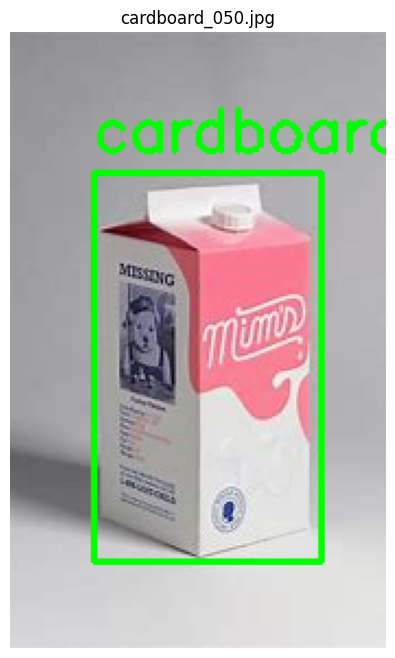

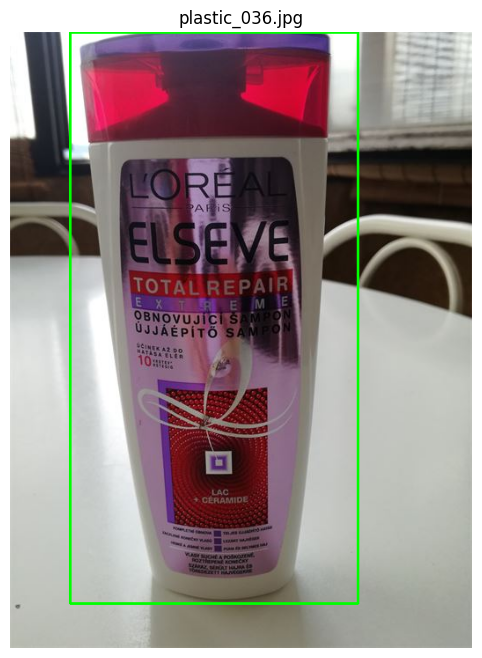

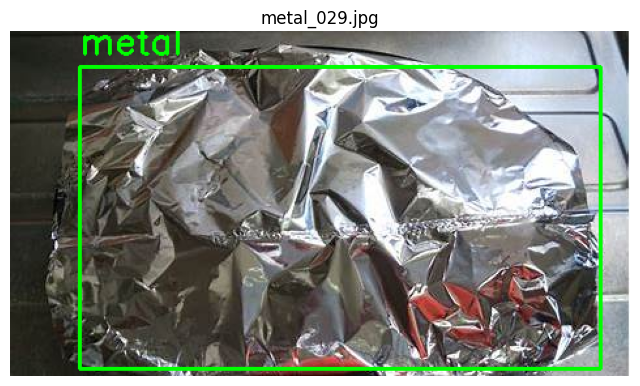

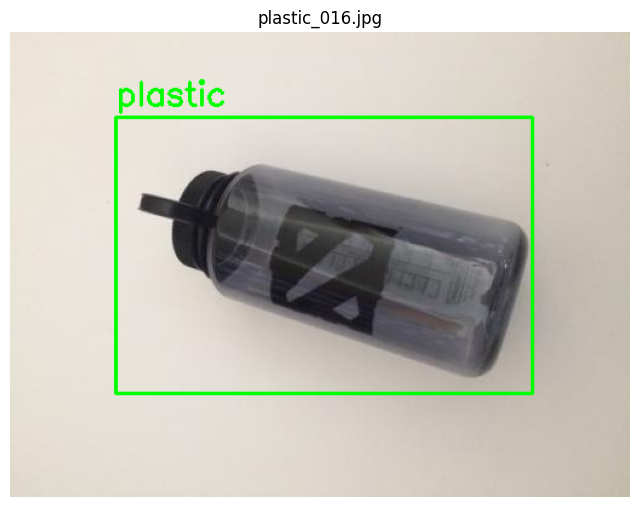

--- Visualizing valid data ---


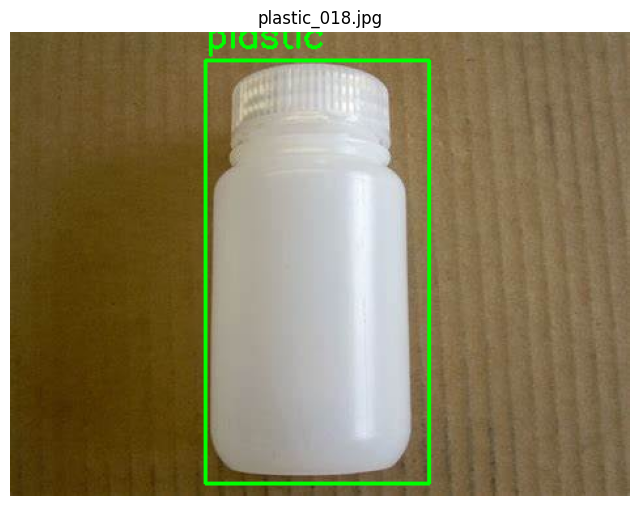

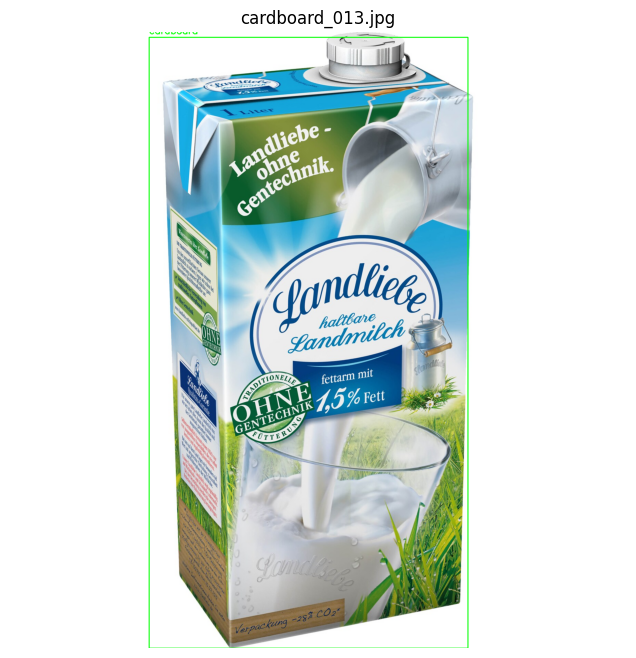

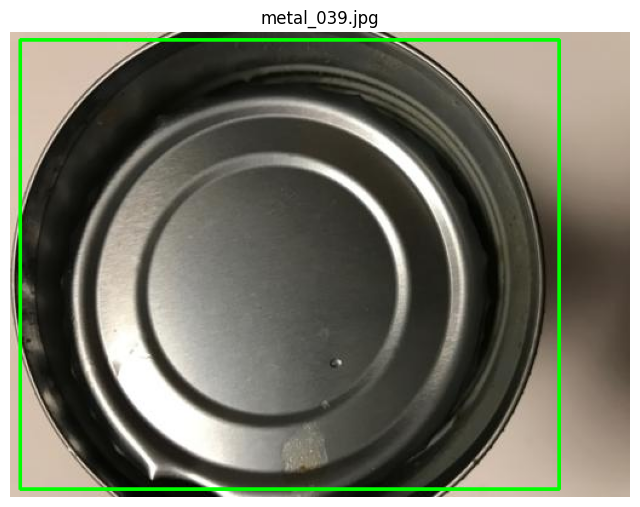

In [7]:
import cv2
import random
import matplotlib.pyplot as plt

dataset_dir = '/kaggle/working/scrap_dataset_split'
CLASS_NAMES = ['cardboard', 'metal', 'plastic'] 

def visualize_annotations(split='train', num_samples=3):
    print(f"--- Visualizing {split} data ---")
    img_dir = os.path.join(dataset_dir, split, 'images')
    lbl_dir = os.path.join(dataset_dir, split, 'labels')
    image_files = random.sample(os.listdir(img_dir), min(num_samples, len(os.listdir(img_dir))))
    
    for img_file in image_files:
        img_path = os.path.join(img_dir, img_file)
        lbl_path = os.path.join(lbl_dir, os.path.splitext(img_file)[0] + '.txt')
        image = cv2.imread(img_path)
        h, w, _ = image.shape
        
        with open(lbl_path, 'r') as f:
            for line in f:
                class_id, x_center, y_center, width, height = map(float, line.split())
                x1, y1 = int((x_center-width/2)*w), int((y_center-height/2)*h)
                x2, y2 = int((x_center+width/2)*w), int((y_center+height/2)*h)
                cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
                label = CLASS_NAMES[int(class_id)]
                cv2.putText(image, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,0), 2)
        
        plt.figure(figsize=(8, 8)); plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)); plt.title(img_file); plt.axis('off'); plt.show()

visualize_annotations('train', num_samples=4)
visualize_annotations('valid', num_samples=3)

# Training YOLO

In [8]:
!pip install -q ultralytics

import os
import shutil
from ultralytics import YOLO

if os.path.exists('/kaggle/working/runs'):
    shutil.rmtree('/kaggle/working/runs')
print("Cleaned up old training runs.")


Cleaned up old training runs.


In [9]:

model = YOLO('yolov8n.pt') 
data_yaml_path = '/kaggle/working/scrap_dataset_split/data.yaml'

results = model.train(
    data=data_yaml_path,
    epochs=150, imgsz=640, batch=8,
    degrees=25.0, translate=0.15, scale=0.6, shear=5.0, 
    perspective=0.0005, flipud=0.5, fliplr=0.5, 
    mosaic=1.0, mixup=0.1,
    project='custom_scrap_sorter',
    name='yolov8m_heavy_aug_corrected',
    patience=15
)

print("--- Training Finished ---")

New https://pypi.org/project/ultralytics/8.3.190 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.189 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/scrap_dataset_split/data.yaml, degrees=25.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8m_heavy_aug_cor

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         30         46      0.893      0.619      0.737      0.486
             cardboard         10         18      0.794      0.643      0.746       0.52
                 metal         12         15      0.885      0.533      0.623      0.478
               plastic          8         13          1      0.681       0.84      0.459
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to custom_scrap_sorter/yolov8m_heavy_aug_corrected
--- Training Finished ---


In [11]:
from ultralytics import YOLO
import os

# The path to your best performing model weights
model_path = '/kaggle/working/custom_scrap_sorter/yolov8m_heavy_aug_corrected/weights/best.pt'

# Load the model
model = YOLO(model_path)

print(f"Successfully loaded model from {model_path}")

Successfully loaded model from /kaggle/working/custom_scrap_sorter/yolov8m_heavy_aug_corrected/weights/best.pt


# Ground truth vs Prediction


image 1/1 /kaggle/working/scrap_dataset_split/valid/images/plastic_013.jpg: 640x640 1 plastic, 6.5ms
Speed: 3.2ms preprocess, 6.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


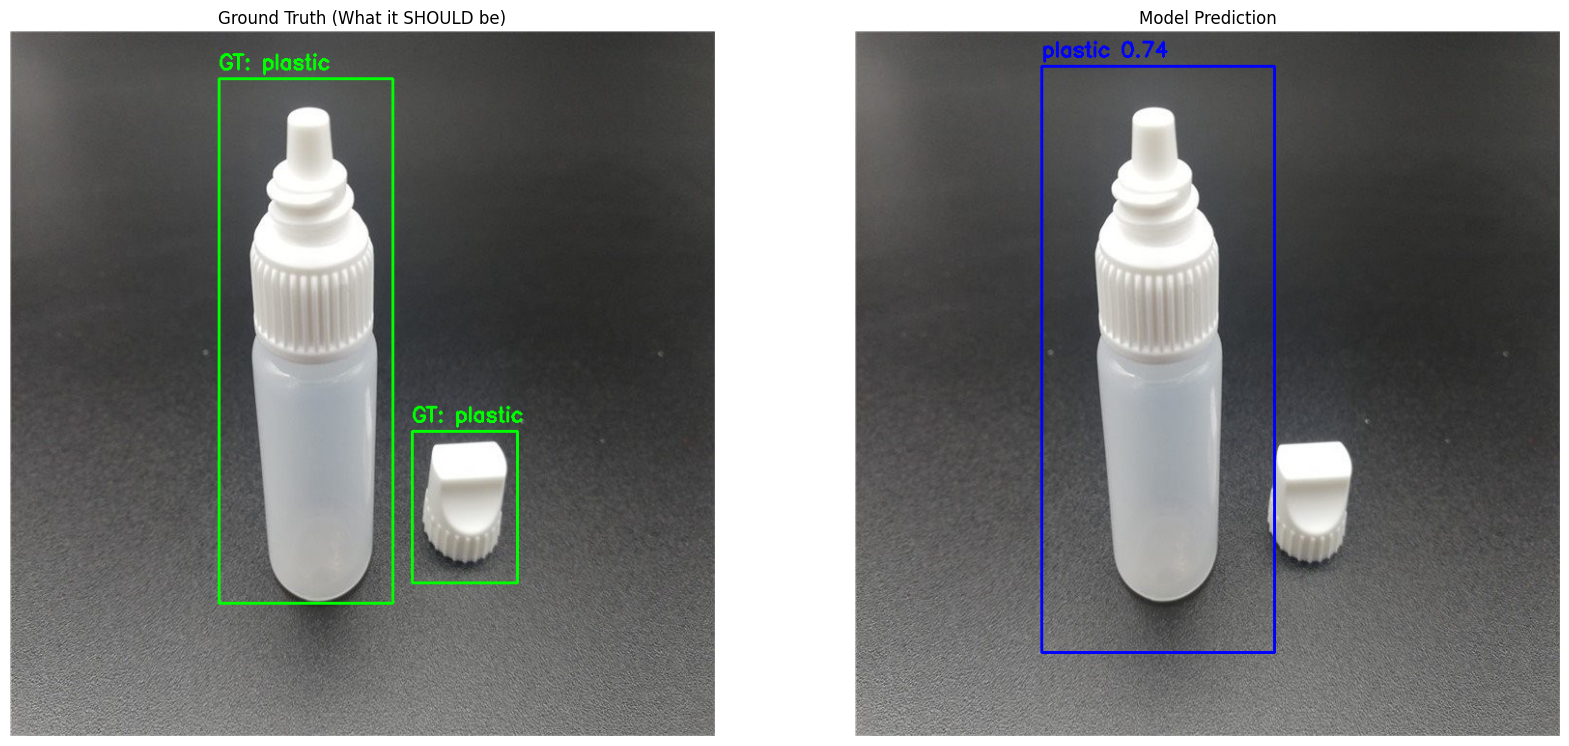


image 1/1 /kaggle/working/scrap_dataset_split/valid/images/metal_030.jpg: 480x640 1 cardboard, 39.7ms
Speed: 2.7ms preprocess, 39.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


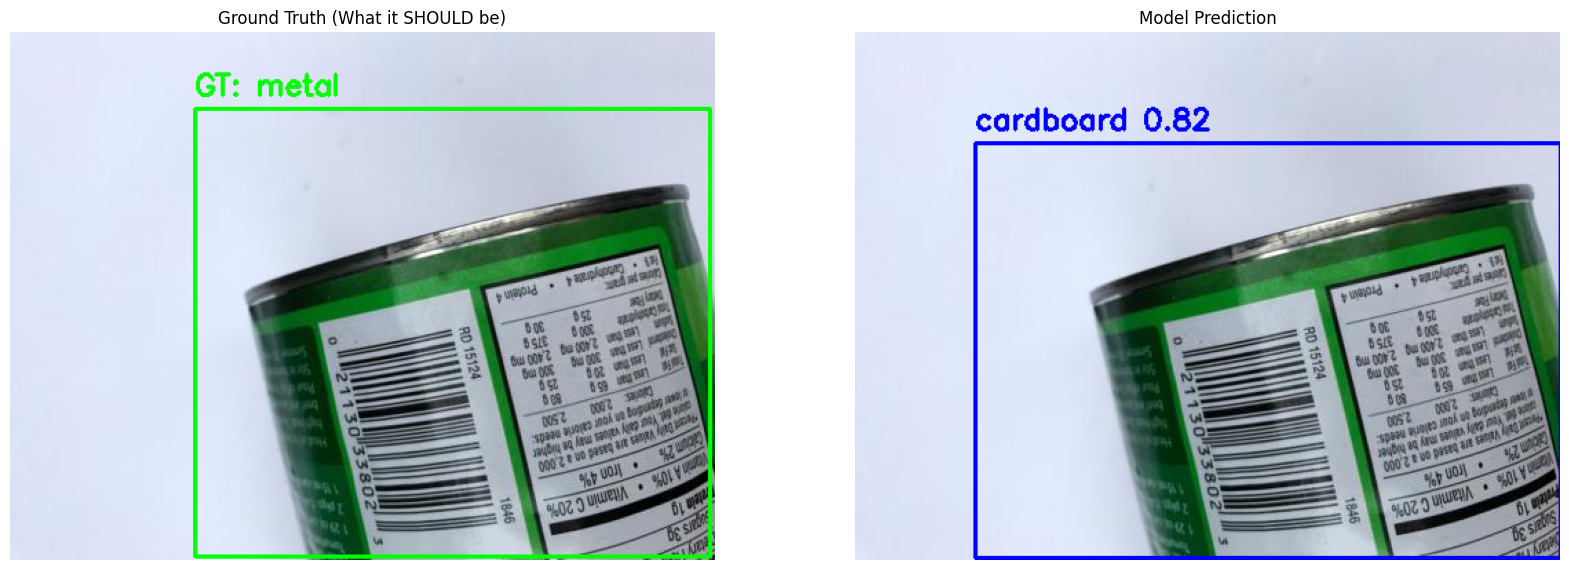


image 1/1 /kaggle/working/scrap_dataset_split/valid/images/plastic_038.jpg: 480x640 1 plastic, 8.7ms
Speed: 3.6ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


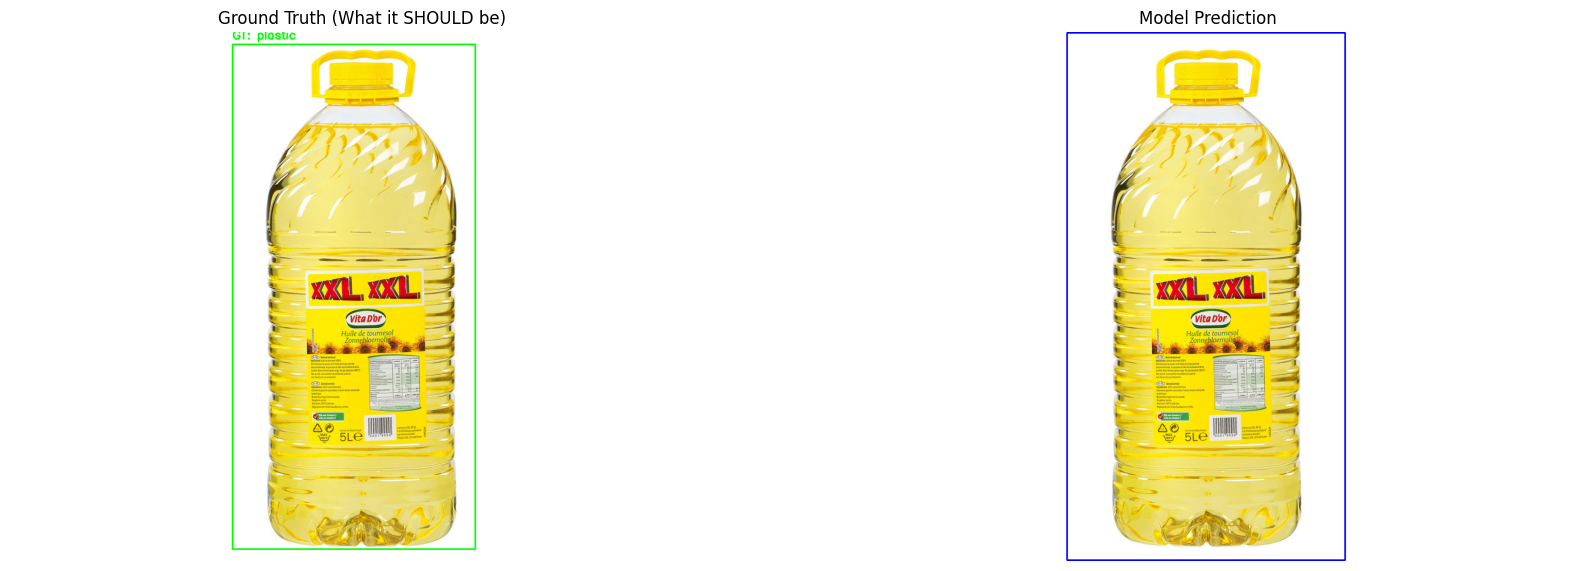

In [12]:
import cv2
import random
import matplotlib.pyplot as plt

# --- Configuration ---
dataset_dir = '/kaggle/working/scrap_dataset_split'
CLASS_NAMES = ['cardboard', 'metal', 'plastic'] 
num_samples_to_show = 3

# --- Get Sample Images ---
valid_img_dir = os.path.join(dataset_dir, 'valid', 'images')
image_files = random.sample(os.listdir(valid_img_dir), num_samples_to_show)

# --- Run Prediction and Visualize ---
for img_file in image_files:
    img_path = os.path.join(valid_img_dir, img_file)
    
    # Run prediction
    results = model.predict(img_path, conf=0.4) # Use a confidence of 40%
    
    # --- Create Visualization ---
    image = cv2.imread(img_path)
    h, w, _ = image.shape
    
    # Create two copies of the image to draw on
    gt_image = image.copy()
    pred_image = image.copy()
    
    # 1. Draw Ground Truth Boxes (in GREEN)
    lbl_path = os.path.join(dataset_dir, 'valid', 'labels', os.path.splitext(img_file)[0] + '.txt')
    with open(lbl_path, 'r') as f:
        for line in f:
            class_id, x_c, y_c, w_b, h_b = map(float, line.split())
            x1, y1 = int((x_c - w_b/2)*w), int((y_c - h_b/2)*h)
            x2, y2 = int((x_c + w_b/2)*w), int((y_c + h_b/2)*h)
            cv2.rectangle(gt_image, (x1, y1), (x2, y2), (0, 255, 0), 2) # Green
            cv2.putText(gt_image, f"GT: {CLASS_NAMES[int(class_id)]}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    # 2. Draw Prediction Boxes (in BLUE)
    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            conf = box.conf[0]
            cls = int(box.cls[0])
            label = f"{CLASS_NAMES[cls]} {conf:.2f}"
            cv2.rectangle(pred_image, (x1, y1), (x2, y2), (255, 0, 0), 2) # Blue
            cv2.putText(pred_image, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

    # --- Display Side-by-Side ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.imshow(cv2.cvtColor(gt_image, cv2.COLOR_BGR2RGB))
    ax1.set_title('Ground Truth (What it SHOULD be)')
    ax1.axis('off')
    
    ax2.imshow(cv2.cvtColor(pred_image, cv2.COLOR_BGR2RGB))
    ax2.set_title('Model Prediction')
    ax2.axis('off')
    
    plt.show()

--- Confusion Matrix ---
Rows = True Class, Columns = Predicted Class


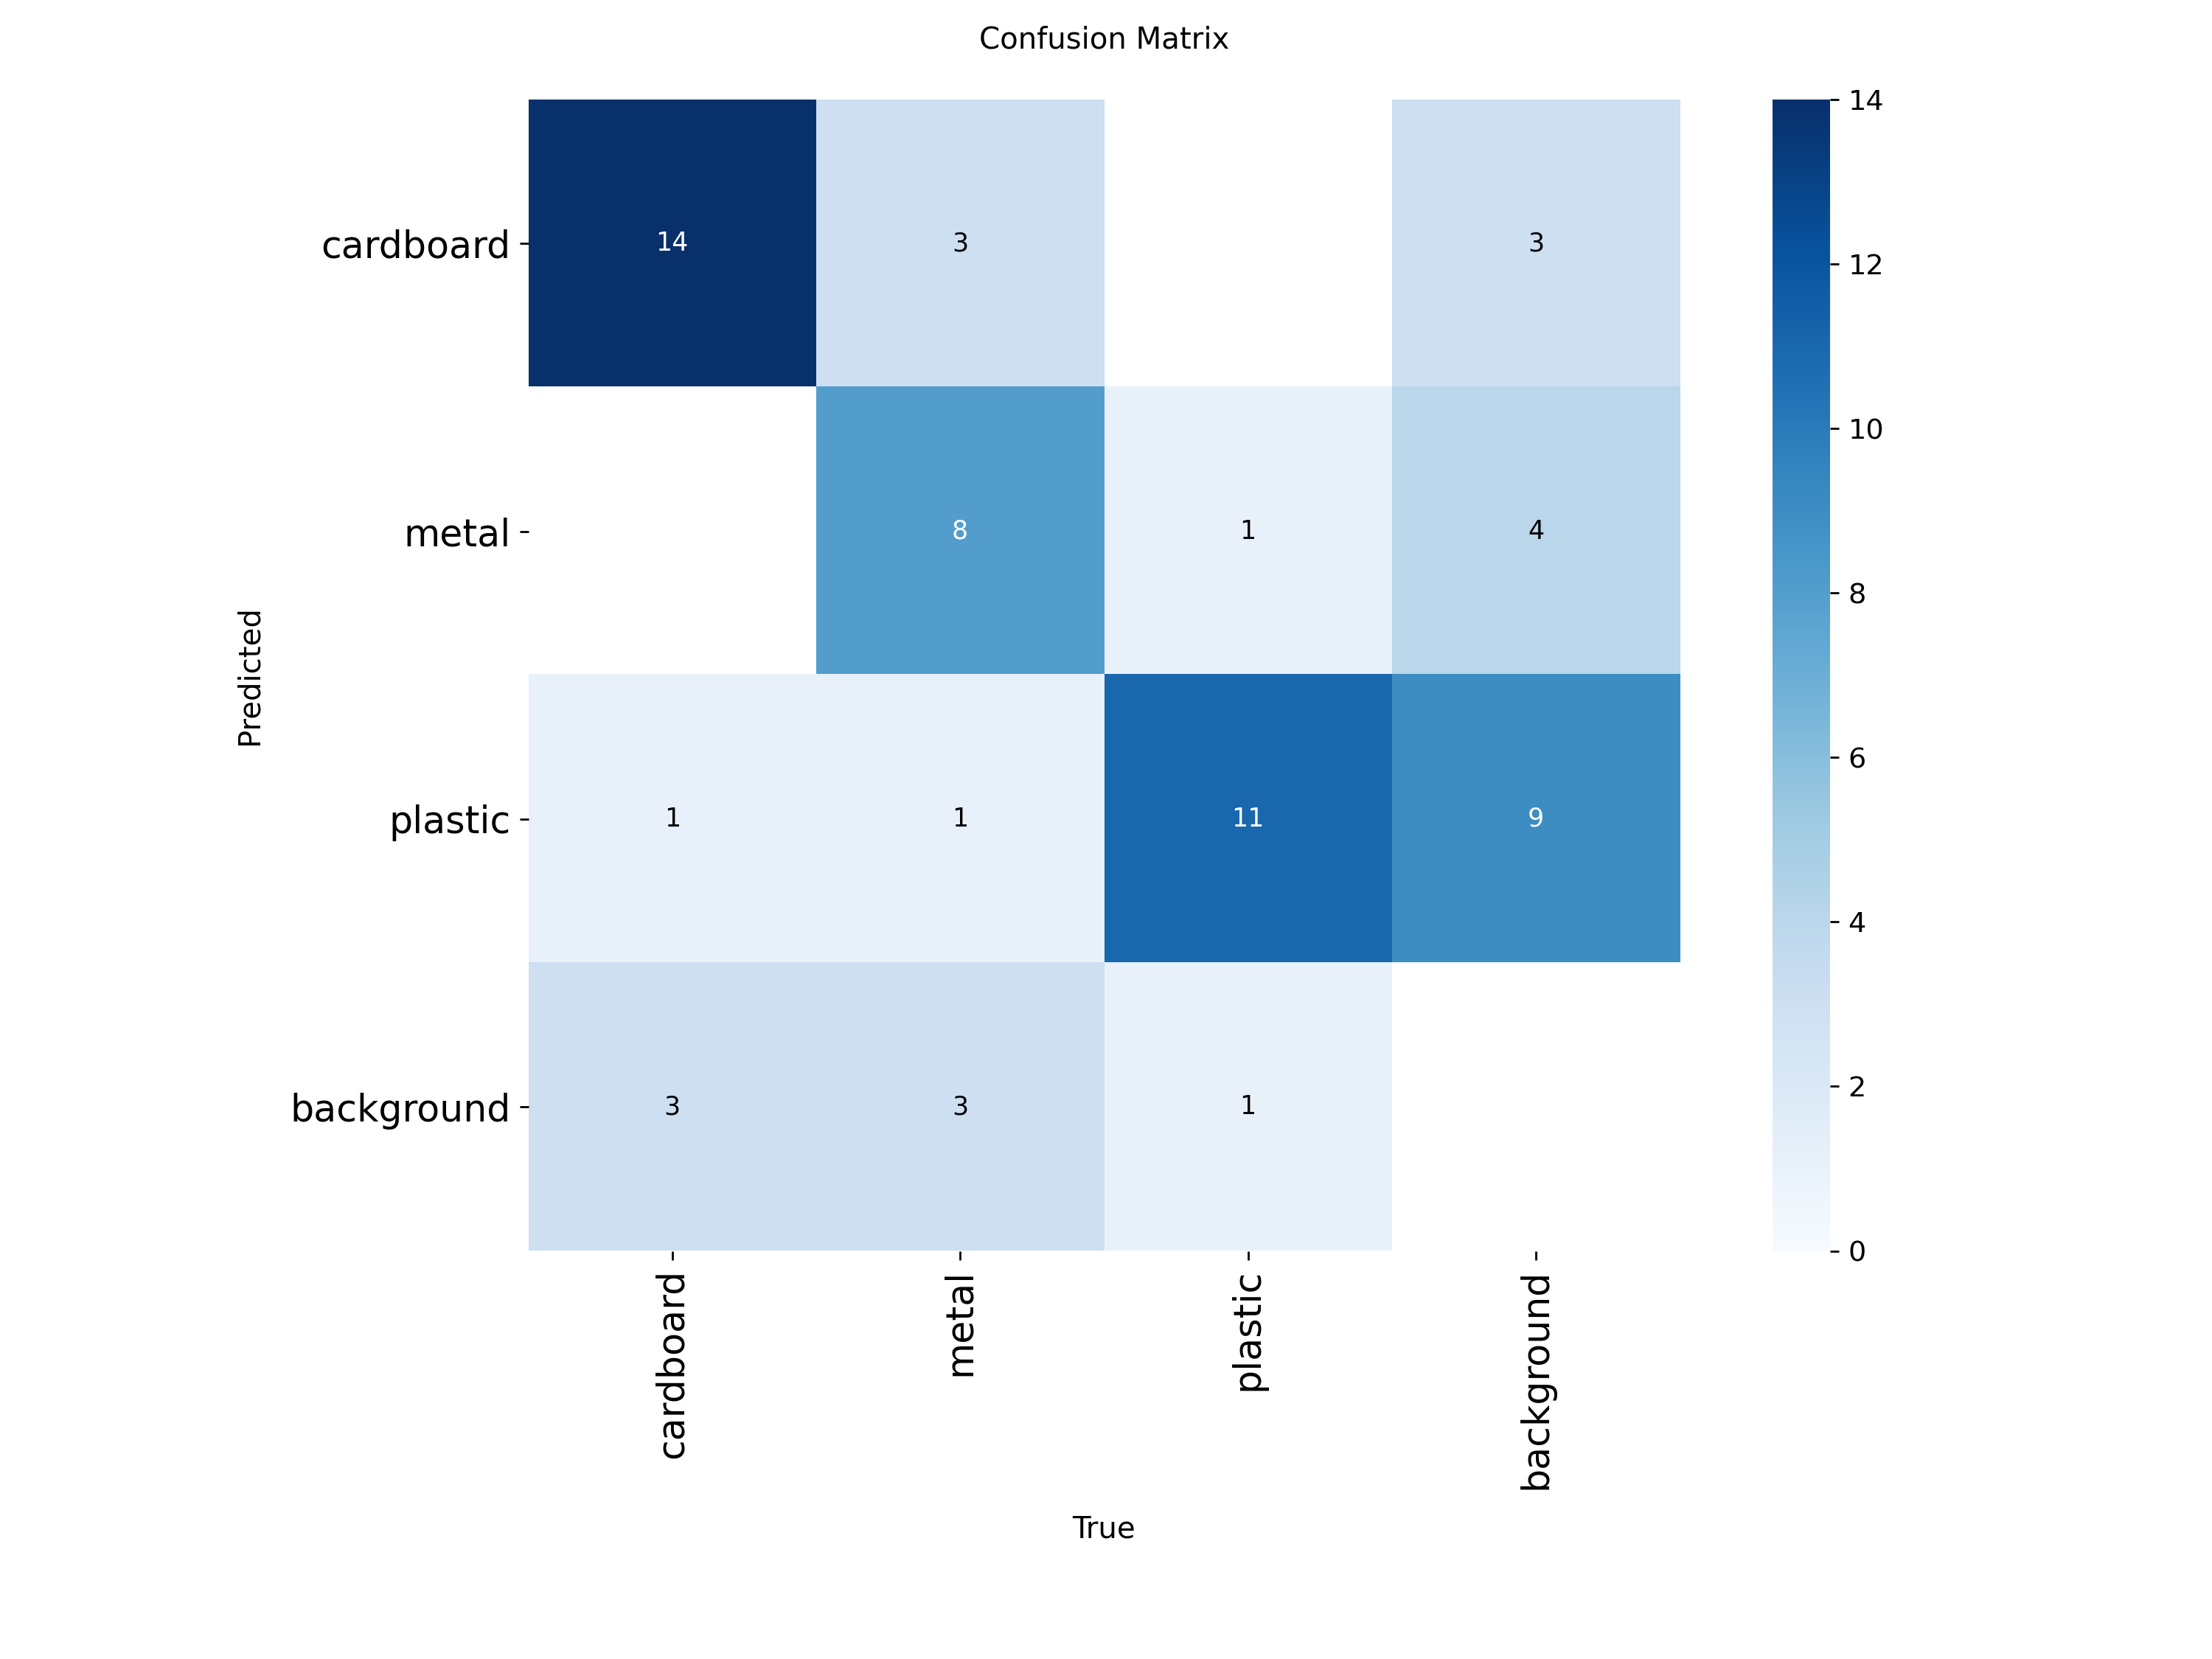


--- Precision-Recall Curve ---
A good model stays in the top-right corner.


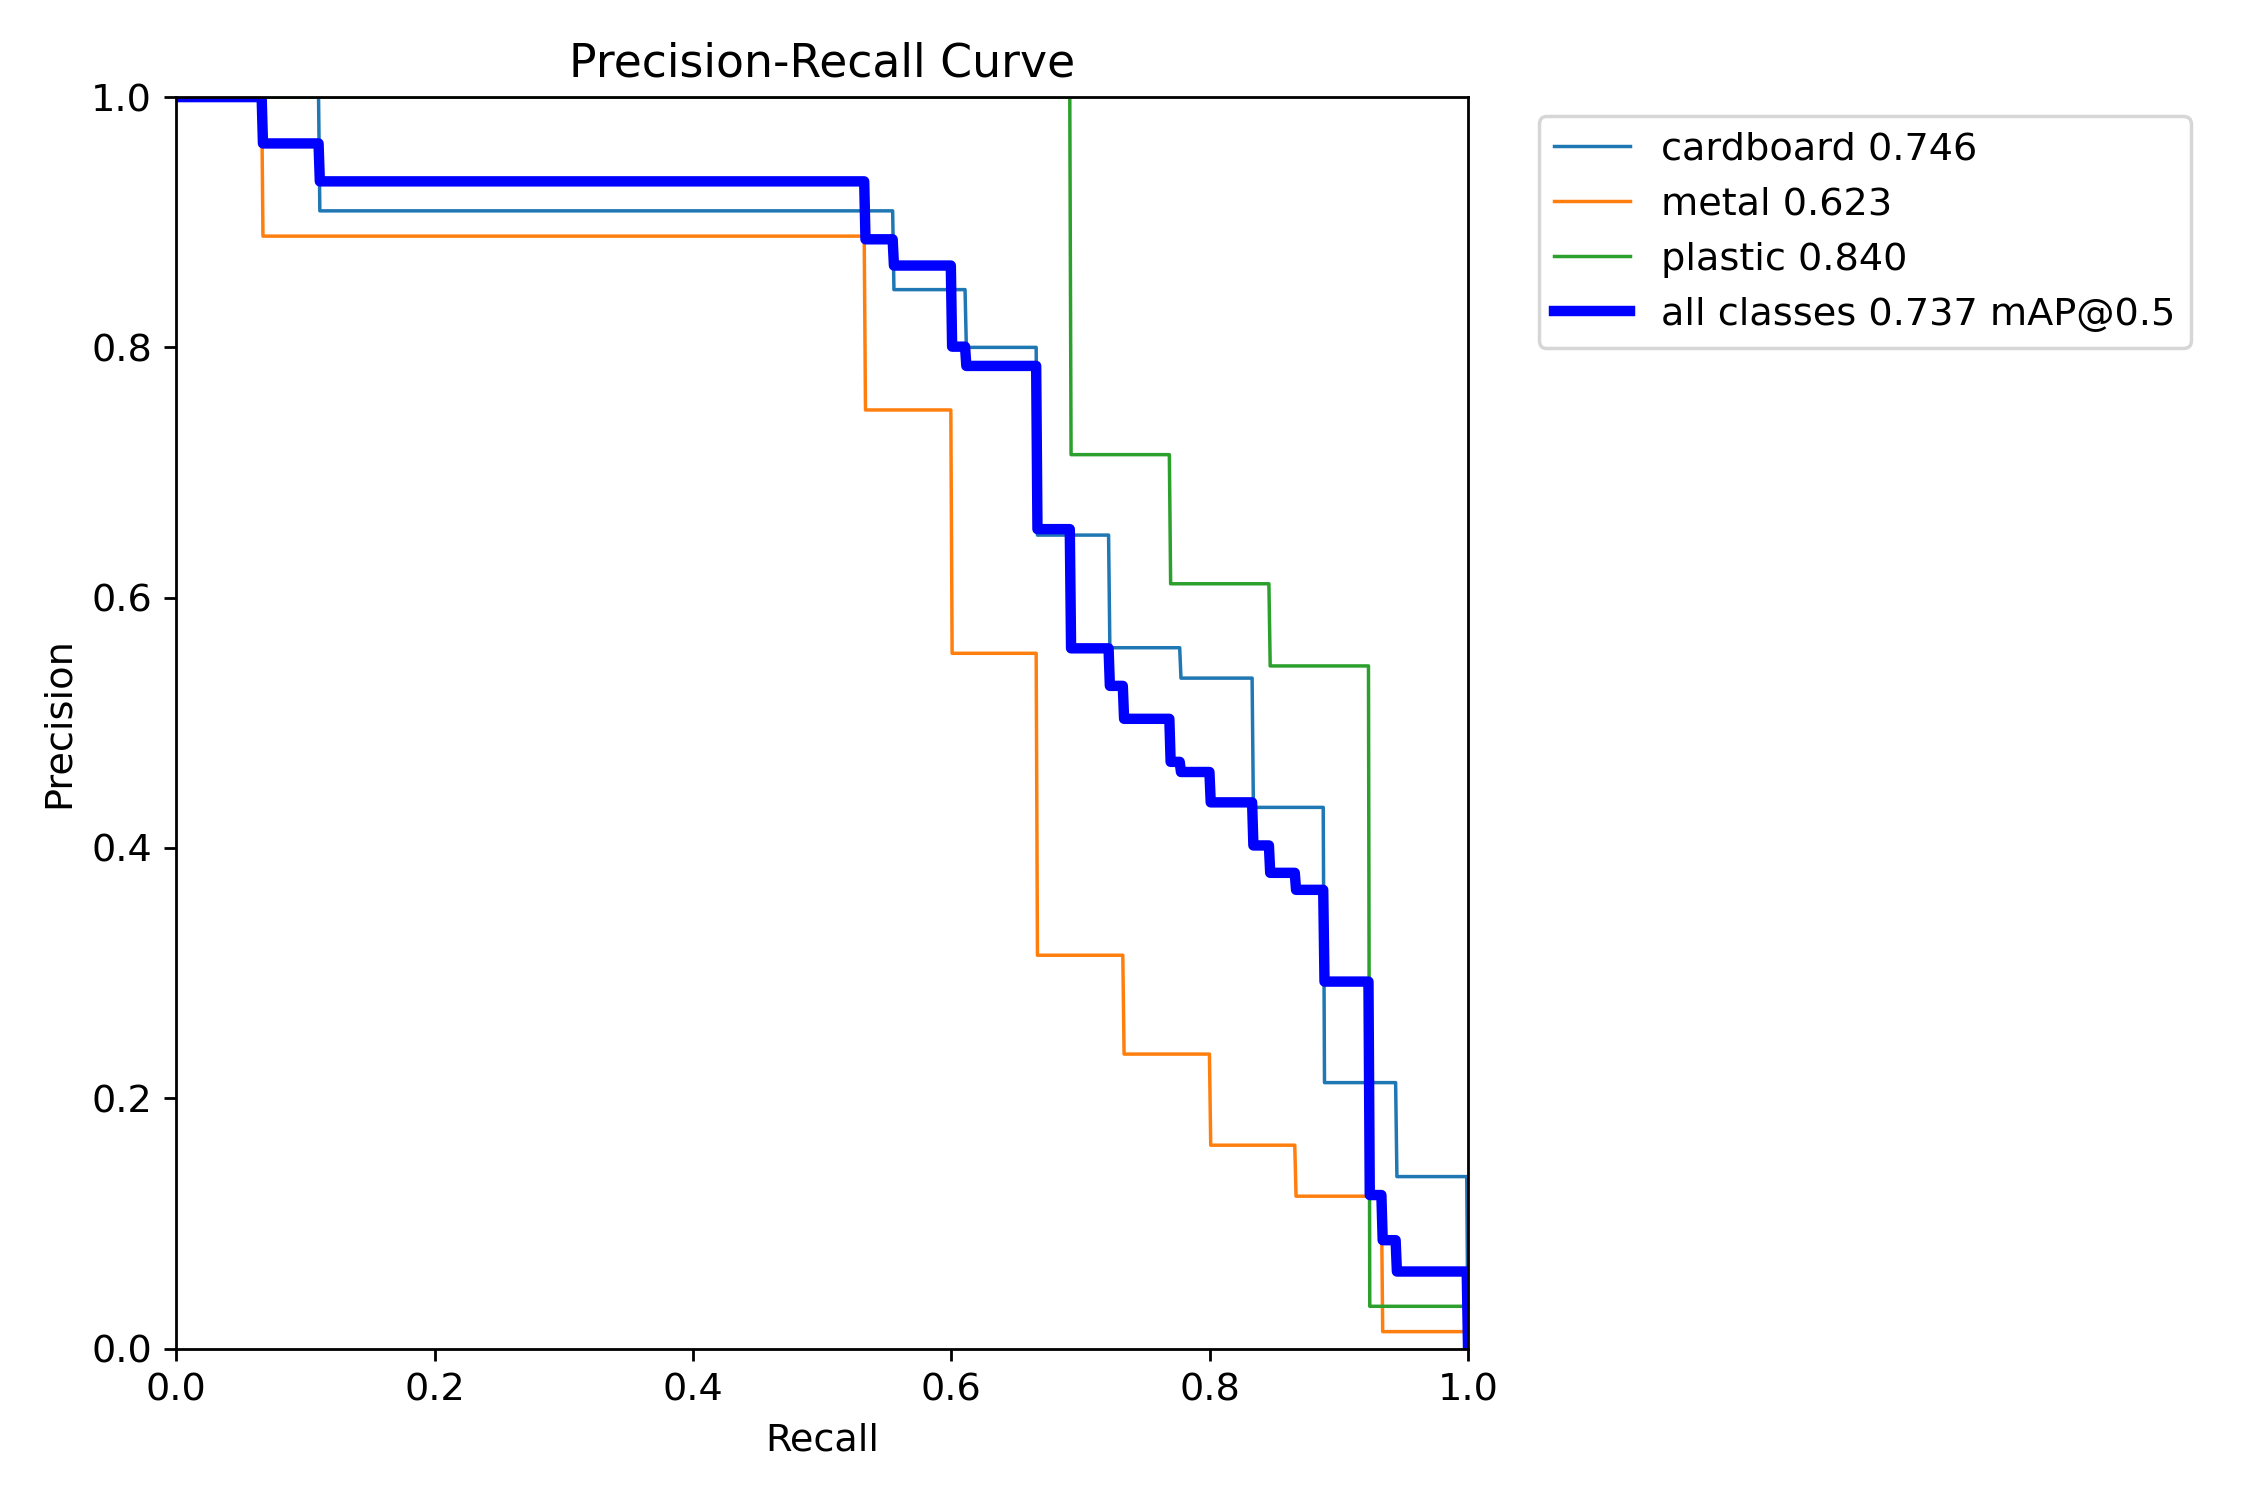

In [15]:
from IPython.display import Image, display

# Path to the directory where results are saved
results_dir = '/kaggle/working/custom_scrap_sorter/yolov8m_heavy_aug_corrected'

# Display the confusion matrix
print("--- Confusion Matrix ---")
print("Rows = True Class, Columns = Predicted Class")
display(Image(filename=os.path.join(results_dir, 'confusion_matrix.png')))

# Display the Precision-Recall Curve
print("\n--- Precision-Recall Curve ---")
print("A good model stays in the top-right corner.")
display(Image(filename=os.path.join(results_dir, 'BoxPR_curve.png')))